In [47]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("../../choroid-plexus/new_annotations.h5ad")
adata = adata[adata.obs["Cell.Subtype"].ne("Doublet")]
adata = adata[::10]

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.external.pp.harmony_integrate(adata, key="orig.ident")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="X_pca_harmony")
sc.tl.umap(adata, min_dist=0.3, spread=1.0, random_state=42)

/Users/jameshaberberger/GitHub/CHOIR/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-06-12 14:54:22,778 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-12 14:54:23,977 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-12 14:54:24,016 - harmonypy - INFO - Iteration 1 of 10
2025-06-12 14:54:25,710 - harmonypy - INFO - Iteration 2 of 10
2025-06-12 14:54:27,441 - harmonypy - INFO - Iteration 3 of 10
2025-06-12 14:54:28,916 - harmonypy - INFO - Iteration 4 of 10
2025-06-12 14:54:30,360 - harmonypy - INFO - Iteration 5 of 10
2025-06-12 14:54:31,674 - harmo

In [49]:
import numpy as np
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

def model_selection(model_type="ensemble"):
    """
    Selects and returns a machine learning model based on the specified model_type.

    Parameters
    ----------
    model_type : str or object, default="ensemble"
        The type of model to select. Supported string values are:
            - "ensemble": RandomForestClassifier from sklearn.ensemble
            - "linear_model": LogisticRegression from sklearn.linear_model
            - "neural_network": MLPClassifier from sklearn.neural_network
        Alternatively, a custom model object can be provided if it implements
        'fit', 'score', and 'predict' methods.

    Returns
    -------
    model : object
        An instance of the selected model.

    Raises
    ------
    ValueError
        If the model_type is not recognized or does not have the required methods.
    """
    # Model Type Selection
    if isinstance(model_type, str):
        print(f"Model type: {model_type}")
        if model_type == "ensemble":
            model = sklearn.ensemble.RandomForestClassifier(class_weight="balanced")
        if model_type == "linear_model":
            model = sklearn.linear_model.LogisticRegression(class_weight="balanced")
        if model_type == "neural_network":
            model = sklearn.neural_network.MLPClassifier(class_weight="balanced")
        return model

    # Duck typing: check if model_type has fit, score, and predict.
    elif all(hasattr(model_type, attr) for attr in ["fit", "score", "predict"]):
        model = model_type
        return model

    else:
        raise ValueError(f"Model type '{model_type}' is not recognized or does not have the required methods.")



In [91]:
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

def optimal_cluster(adata, resolution_range=(0.10, 2.0, 0.10), alpha=0.95, model_type = "linear_model", test_size = 0.5, batch_key="orig.ident"):
    """
    Find the optimal clustering resolution for the given AnnData object.
    
    Parameters:
    adata (AnnData): The annotated data matrix.
    resolution_range (tuple): A tuple defining the range of resolutions to test.
    alpha (float): Hypothesis testing alpha by bootstrapped estimators.
    test_size (float): Test size when performing test-train split (fraction of the population).
    
    Returns:
    None: The function modifies the adata object in place.
    """
    # Fitted Labels
    new_labels = None

    adata_copy = adata.copy()
    sc.tl.pca(adata_copy, svd_solver="arpack")

    if batch_key in adata.obs.columns and adata.obs["orig.ident"].nunique() > 1:
        sc.external.pp.harmony_integrate(adata_copy, key="orig.ident")
    else:
        print("Skipping Harmony: insufficient metadata in 'orig.ident'")

    sc.pp.neighbors(adata_copy, n_neighbors=10, n_pcs=10, use_rep="X_pca_harmony")

    # If there user has selected highly variable genes, filter the data.
    if "highly_variable" in adata.var.columns:
        adata_copy = adata_copy[:, adata_copy.var["highly_variable"]]

    # Create a copy.
    X = adata_copy.X
    y = None

    model = model_selection(model_type)

    # Iterative clustering.
    for res in np.arange(resolution_range[0], resolution_range[1] + resolution_range[1], resolution_range[2]):
        # Fuck rounding errors.
        res = round(res, 2)

        # Generate clusters.
        sc.tl.leiden(adata_copy, resolution=res, flavor='igraph', n_iterations=2)

        if adata_copy.obs['leiden'].nunique() == 1:
            continue

        y = adata_copy.obs['leiden']

        # Get the labels, test train split.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)

        if accuracy > alpha:
            new_labels = y

        else:
            clear_output(wait=True)
            print(f"Resolution {res} failed the stability test. Accuracy = {round(accuracy, 3)}")
            return round(res - resolution_range[2], 2), new_labels

    return round(res, 2), new_labels

In [219]:
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def optimal_cluster(
    adata, 
    resolution_range=(0.10, 2.0, 0.10), 
    alpha=0.95, 
    model_type="linear_model", 
    test_size=0.5, 
    batch_key="orig.ident"
):
    """
    Find the optimal clustering resolution for the given AnnData object,
    ensuring minimum per-class test accuracy never falls below `alpha`.
    """
    new_labels = None
    adata_copy = adata.copy()
    sc.tl.pca(adata_copy, svd_solver="arpack")

    if batch_key in adata.obs.columns and adata.obs[batch_key].nunique() > 1:
        sc.external.pp.harmony_integrate(adata_copy, key=batch_key)
    else:
        print(f"Skipping Harmony: insufficient metadata in '{batch_key}'")

    sc.pp.neighbors(adata_copy, n_neighbors=20, n_pcs=20, use_rep="X_pca_harmony")

    if "highly_variable" in adata.var.columns:
        adata_copy = adata_copy[:, adata_copy.var["highly_variable"]]

    X = adata_copy.X
    model = model_selection(model_type)

    for res in np.arange(resolution_range[0], resolution_range[1] + resolution_range[2], resolution_range[2]):
        res = round(res, 2)
        sc.tl.leiden(adata_copy, resolution=res, flavor='igraph', n_iterations=2)

        if adata_copy.obs['leiden'].nunique() == 1:
            continue

        y = adata_copy.obs['leiden']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        per_class_accuracies = []
        for label in y_test.cat.categories:
            idx = y_test == label
            if idx.sum() == 0:
                continue
            acc = accuracy_score(y_test[idx], y_pred[idx])
            per_class_accuracies.append(acc)

        min_acc = min(per_class_accuracies)
        if min_acc >= alpha:
            new_labels = y
        else:
            clear_output(wait=True)
            print(f"Resolution {res} failed: min class accuracy = {round(min_acc, 3)}")
            return round(res - resolution_range[2], 2), new_labels

    return round(res, 2), new_labels


In [ ]:
res, labels = optimal_cluster(adata, alpha=.98)
adata.obs[f"choir_level_0"] = labels

In [ ]:
import pandas as pd

for level in range(3):
    col = f"choir_level_{level + 1}"
    adata.obs[col] = adata.obs[f"choir_level_{level}"]

    for parent_label in adata.obs[f"choir_level_{level}"].cat.categories:
        if parent_label[-1] != "X":
            indexer = adata.obs[f"choir_level_{level}"] == parent_label

            if indexer.sum() < 100:
                continue

            res, labels = optimal_cluster(
                adata[indexer],
                resolution_range=(0.1, 2.0, 0.1),
                alpha=0.7,
                model_type="linear_model",
                test_size=0.5,
            )

            if labels is None:
                new_labels = [f"{parent_label}.X"] * indexer.sum()
            else:
                unique_labels = pd.unique(labels)
                new_labels = [f"{parent_label}.{lbl}" for lbl in labels]

            # Set categories to allow assignment
            new_cats = pd.unique(new_labels)
            adata.obs[col] = adata.obs[col].cat.add_categories(new_cats)
            adata.obs.loc[indexer, col] = new_labels

Resolution 0.5 failed: min class accuracy = 0.538


/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_29196/3047521391.py:29: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  new_cats = pd.unique(new_labels)


In [222]:
def clean_unused_categories_and_palettes(adata, keys):
    for key in keys:
        if key in adata.obs and pd.api.types.is_categorical_dtype(adata.obs[key]):
            # Drop unused categories
            adata.obs[key] = adata.obs[key].cat.remove_unused_categories()
            
            # Fix or remove corresponding palette
            uns_key = f"{key}_colors"
            if uns_key in adata.uns:
                n_cats = len(adata.obs[key].cat.categories)
                current_palette = adata.uns[uns_key]
                if len(current_palette) > n_cats:
                    adata.uns[uns_key] = current_palette[:n_cats]
                elif len(current_palette) < n_cats:
                    # Not enough colors — remove and let Scanpy regenerate
                    del adata.uns[uns_key]

clean_unused_categories_and_palettes(adata, ["choir_level_0", "choir_level_1", "choir_level_2", "choir_level_3"])

/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_29196/1709904127.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if key in adata.obs and pd.api.types.is_categorical_dtype(adata.obs[key]):


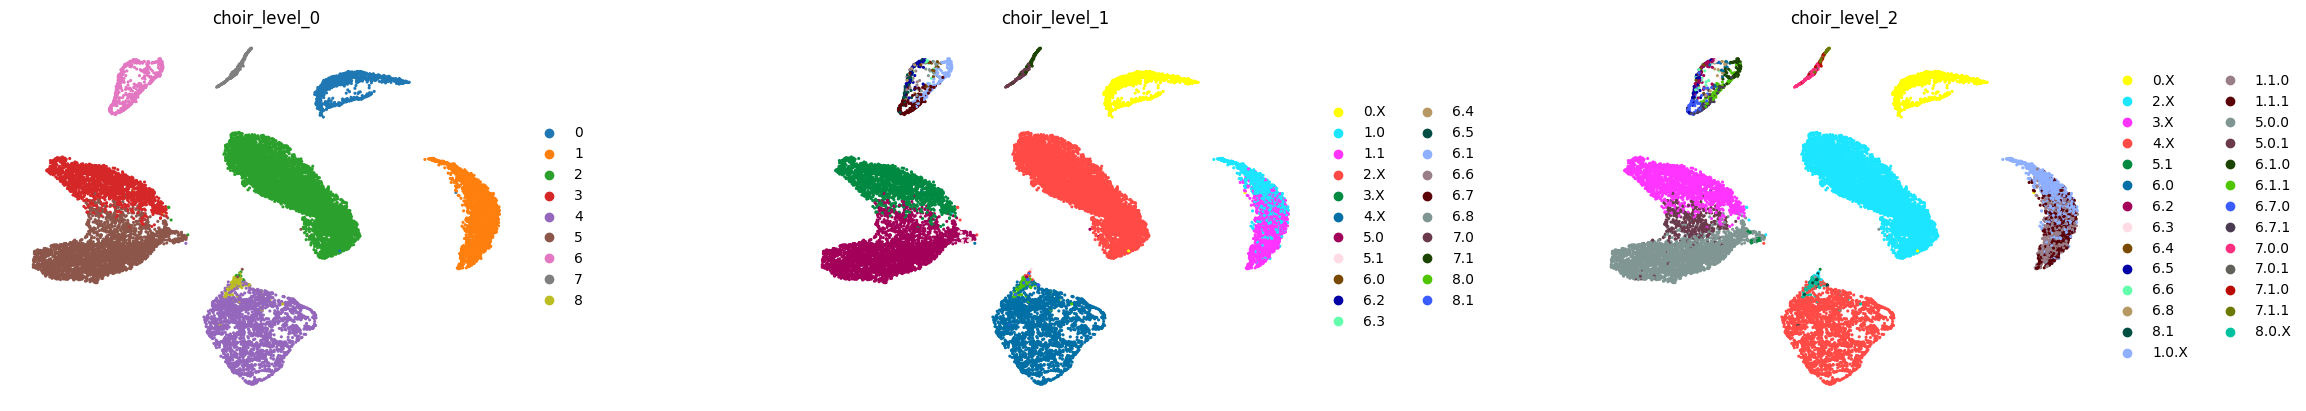

In [224]:
sc.pl.umap(
    adata,
    color=["choir_level_0", "choir_level_1", "choir_level_2"], 
    frameon=False,
    wspace=0.4,
    hspace=0.4,
    size=20
)

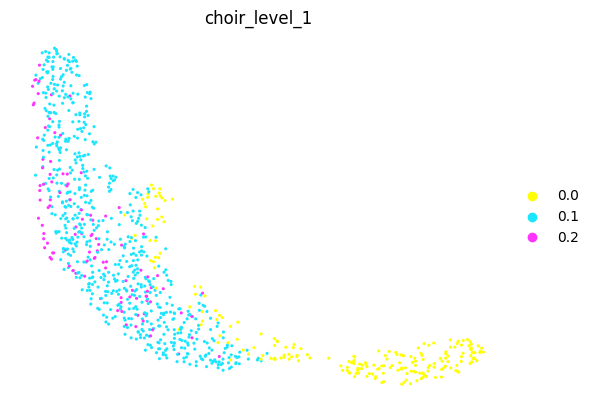

In [218]:
test_subset = adata[
    adata.obs["choir_level_0"].eq("0")
]

sc.pp.neighbors(test_subset, n_neighbors=20, n_pcs=20, use_rep="X_pca_harmony")
sc.tl.umap(test_subset, min_dist=0.3, spread=1.0, random_state=42)
sc.pl.umap(
    test_subset,
    color=["choir_level_1"], 
    frameon=False, wspace=0.4, hspace=0.4, size=20,
    cmap="tab20"
)

/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_29196/3801979358.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  adata.obs.pivot_table(index="Cell.State", columns="choir_level_3", aggfunc="size").fillna(0).astype(int),


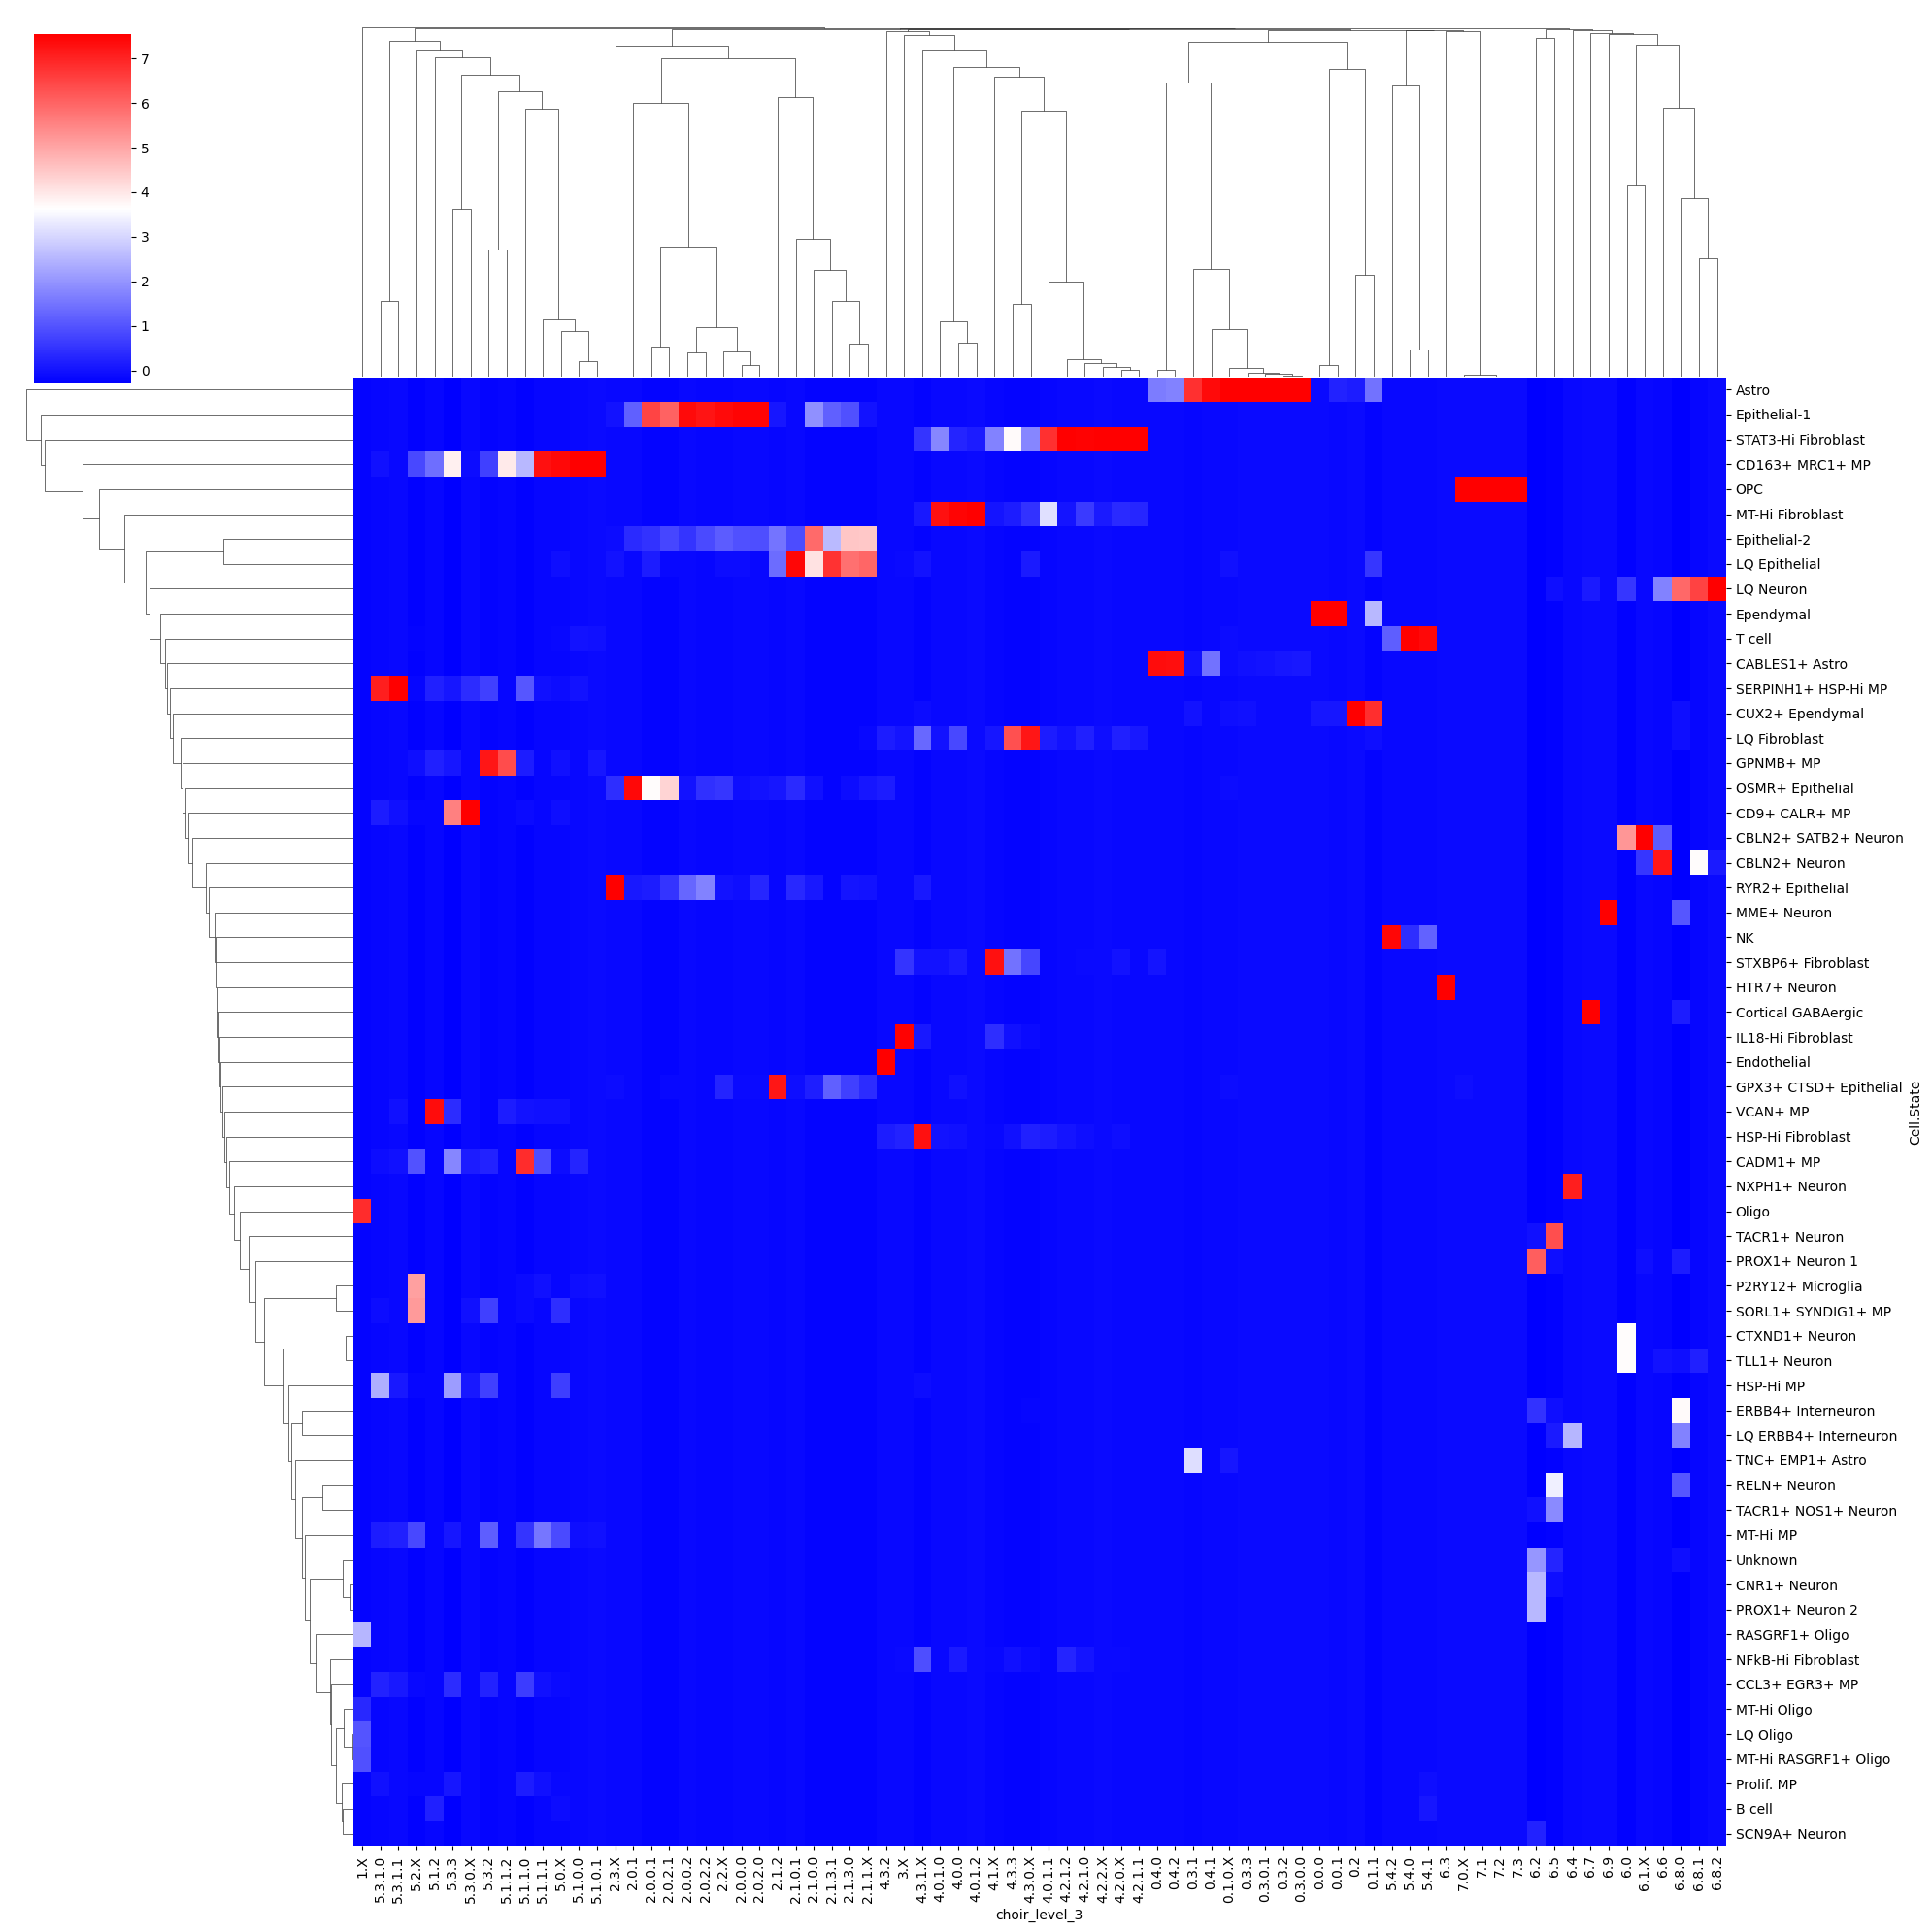

In [177]:
import seaborn as sns

sns.clustermap(
    adata.obs.pivot_table(index="Cell.State", columns="choir_level_3", aggfunc="size").fillna(0).astype(int),
    z_score=1,
    figsize=(20, 20),
    cmap="bwr",
    yticklabels=True,
)